In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from gnn import GraphNetnoSV
from gnn import GraphNet
from gnn import GraphNetAllParticle
from data import H5Data
import glob
import json
from sklearn.metrics import roc_curve, auc, roc_auc_score


params = ['track_ptrel',
          'track_erel',
          'track_phirel',
          'track_etarel',
          'track_deltaR',
          'track_drminsv',
          'track_drsubjet1',
          'track_drsubjet2',
          'track_dz',
          'track_dzsig',
          'track_dxy',
          'track_dxysig',
          'track_normchi2',
          'track_quality',
          'track_dptdpt',
          'track_detadeta',
          'track_dphidphi',
          'track_dxydxy',
          'track_dzdz',
          'track_dxydz',
          'track_dphidxy',
          'track_dlambdadz',
          'trackBTag_EtaRel',
          'trackBTag_PtRatio',
          'trackBTag_PParRatio',
          'trackBTag_Sip2dVal',
          'trackBTag_Sip2dSig',
          'trackBTag_Sip3dVal',
          'trackBTag_Sip3dSig',
          'trackBTag_JetDistVal'
         ]

params_sv = ['sv_ptrel',
          'sv_erel',
          'sv_phirel',
          'sv_etarel',
          'sv_deltaR',
          'sv_pt',
          'sv_mass',
          'sv_ntracks',
          'sv_normchi2',
          'sv_dxy',
          'sv_dxysig',
          'sv_d3d',
          'sv_d3dsig',
          'sv_costhetasvpv'
         ]


batch_size = 1024
files = glob.glob("dataset/train/newdata_*.h5")
files_val = files[:5] # take first 5 for validation
data_val = H5Data(batch_size = batch_size,
                  cache = None,
                  preloading=0,
                  features_name='training_subgroup',
                  labels_name='target_subgroup',
                  spectators_name='spectator_subgroup')
data_val.set_file_names(files_val)



softmax = torch.nn.Softmax(dim=1)
gnn_0 = GraphNet(60, 2, len(params), 60, 5, len(params_sv),
                 vv_branch=0,
                 De=20,
                 Do=24)
training_all = []
training_sv_all = []
gnn_0.load_state_dict(torch.load('IN_training/gnn_new_DR0_best.pth'))

<All keys matched successfully>

In [2]:
def eval(model,
         drop_pfeatures = torch.tensor([], dtype=torch.long),
         drop_svfeatures = torch.tensor([], dtype=torch.long),
         save_data = False):
    lst = []
    correct = []
    
    with torch.no_grad():
        for sub_X,sub_Y,sub_Z in data_val.generate_data():# tqdm.tqdm(,total=n_train/batch_size):                                                                   
            training = sub_X[2]
            training_sv = sub_X[3]
            if save_data:
                training_all.append(training)
                training_sv_all.append(training_sv)
            target = sub_Y[0]
            spec = sub_Z[0]
            trainingv = (torch.FloatTensor(training)).cuda()
            # trainingv = trainingv[:,:,column_shuffle]
            if len(drop_pfeatures) > 0:
                keep_features = [i for i in np.arange(0,len(params),1, dtype=int) if i not in drop_pfeatures]
                trainingv = trainingv[:,keep_features,:]
            trainingv_sv = (torch.FloatTensor(training_sv)).cuda()
            if len(drop_svfeatures) > 0:
                keep_features = [i for i in np.arange(0,len(params_sv),1, dtype=int) if i not in drop_svfeatures]
                trainingv_sv = trainingv_sv[:,keep_features,:]
            targetv = (torch.from_numpy(np.argmax(target, axis = 1)).long()).cuda()
    
            out = model.forward(trainingv.cuda(), trainingv_sv.cuda())
            lst.append(softmax(out).cpu().data.numpy())
            correct.append(target)
    
    predicted = np.concatenate(lst)
    val_targetv = np.concatenate(correct)
    
    return predicted, val_targetv



In [3]:
class ModelComparison:
    def __init__(self, preds, targets, model_tags):
        self.preds = preds
        self.targets = targets
        self.n_models = len(preds)
        self.model_tags = model_tags
        self.aucs_roc = []
        self.aucs_prc = []
        self.fidelity = []
        
    def plot_roc(self, fname):
        if len(self.preds) > 4:
            plt.figure(figsize=(8,8))
        else:
            plt.figure(figsize=(4,4))    
        for ii in range(self.n_models):
            fpr, tpr, _ = roc_curve(self.targets[ii], self.preds[ii])
            self.aucs_roc.append(auc(fpr, tpr))
            #print(self.model_tags[ii])
            plt.plot(fpr, tpr, 
                     label=self.model_tags[ii] + " ({:.2f}%)".format(self.aucs_roc[ii]*100))
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim([1e-5, 1.00])
        plt.ylim([1e-2, 1.00])
        plt.xlabel('FPR', fontsize = 20)
        plt.ylabel('TPR', fontsize = 20)
        plt.legend(loc='lower right')
        plt.savefig(fname)
        plt.show()
        return self.aucs_roc
    
    def plot_prc(self, fname):
        if len(self.preds) > 4:
            plt.figure(figsize=(8,8))
        else:
            plt.figure(figsize=(4,4))
        for ii in range(self.n_models):
            precision, recall, _ =  precision_recall_curve(self.targets[ii], self.preds[ii])
            self.aucs_prc.append(auc(recall, precision))
            #print(self.model_tags[ii])
            plt.plot(recall, precision, 
                     label=self.model_tags[ii] + " ({:.2f}%)".format(self.aucs_prc[ii]*100))
        plt.xlabel('Recall', fontsize = 20)
        plt.ylabel('Precision', fontsize = 20)
        plt.legend(loc='lower left')
        plt.savefig(fname)
        plt.show()
        return self.aucs_prc
    
    def get_fidelity(self, pred_0):
        for ii in range(self.n_models):
            self.fidelity.append(1.0 - np.mean(np.abs(pred_0 - self.preds[ii])))
        return self.fidelity

def print_scores(vals, model_tags, mode='roc' ):
    if mode == 'roc':
        statement = "ROC AUC for {}: {:.2f}"
    if mode == 'prc':
        statement = "PRC AUC for {}: {:.2f}"
    if mode == 'fidelity':
        statement = "Fidelity for {}: {:.2f}"
    for ii in range(len(model_tags)):
        print(statement.format(model_tags[ii], vals[ii]*100))    

In [4]:
### Let's get the baseline model prediction first

pred_0, target_0 = eval(gnn_0, save_data = True)

In [5]:
def dAUC_chart(dAUC_vals_roc, tags, fname, dAUC_vals_prc=[]):
    plot_auc_rpc = False
    if len(dAUC_vals_prc) == len(dAUC_vals_roc):
        kfact = 2
        plot_auc_rpc = True
    else:
        kfact = 1
    pos = kfact*np.arange(len(dAUC_vals_roc))
    if len(tags) < 10:
        plt.figure(figsize=(4,4))
    else:
        plt.figure(figsize=(8,8))
    plt.bar(pos, dAUC_vals_roc, align='center', label='ROC curve')
    if plot_auc_rpc:
        plt.bar(pos+1, dAUC_vals_roc, align='center', label='Precision-Recall Curve')
    plt.xticks(pos+0.5*plot_auc_rpc, tags, rotation='vertical')
    plt.ylabel('Percent Drop in AUC')
    if plot_auc_rpc:
        plt.legend()
    plt.savefig(fname)
    plt.show()
    
def fidelity_chart(fidelity_vals, tags, fname):
    if len(tags) < 10:
        plt.figure(figsize=(4,4))
    else:
        plt.figure(figsize=(8,8))
    pos = np.arange(len(fidelity_vals))
    plt.bar(pos, 1.0 - np.array(fidelity_vals), align='center')
    plt.xticks(pos, tags, rotation='vertical')
    plt.ylabel('1 - F')
    plt.savefig(fname)
    plt.show()

In [6]:
### Now let's get the other models
import os
All_Models = sorted(list(os.listdir("Model_Dicts/")))
model_output_preds = [pred_0[:,1]]
model_output_targets = [target_0[:,1]]
model_output_tags = ['baseline']

for model_file in All_Models:
    if 'pfeaturesdropped' not in model_file:
        continue
    if 'hidden' in model_file or 'De' in model_file or 'Do' in model_file:
        continue
    model_md = json.load(open("Model_Dicts/" + model_file))
    model_name = 'IN_training/' + model_file.replace('model_metadata.json', 'best.pth')
    model_tag = model_md['label']
    drop_pfeatures = model_md['drop_pfeatures']
    if drop_pfeatures != "":
        drop_pfeatures = list(map(int, drop_pfeatures.split(','))) 
    else:
        drop_pfeatures = []
        
    drop_svfeatures = model_md['drop_svfeatures']
    if drop_svfeatures != "":
        drop_svfeatures = list(map(int, drop_svfeatures.split(','))) 
    else:
        drop_svfeatures = []
        
    this_gnn = GraphNet(60, 2, len(params) - len(drop_pfeatures), 
                        60, 5, len(params_sv) - len(drop_svfeatures),
                        vv_branch=0,
                        De=20,
                        Do=24)
    this_gnn.load_state_dict(torch.load(model_name))
    pred, target = eval(this_gnn, drop_pfeatures = drop_pfeatures, drop_svfeatures = drop_svfeatures)
    model_output_preds.append(pred[:,1])
    model_output_targets.append(target[:,1])
    threshold = model_tag.split('_')[1]
    threshold = threshold[0] + '.' + threshold[1:]
    if 'preload' not in model_file:
        model_output_tags.append('Drop Threshold: {}%'.format(threshold))
    else:
        model_output_tags.append('Drop Threshold: {}%,preloaded weight'.format(threshold))

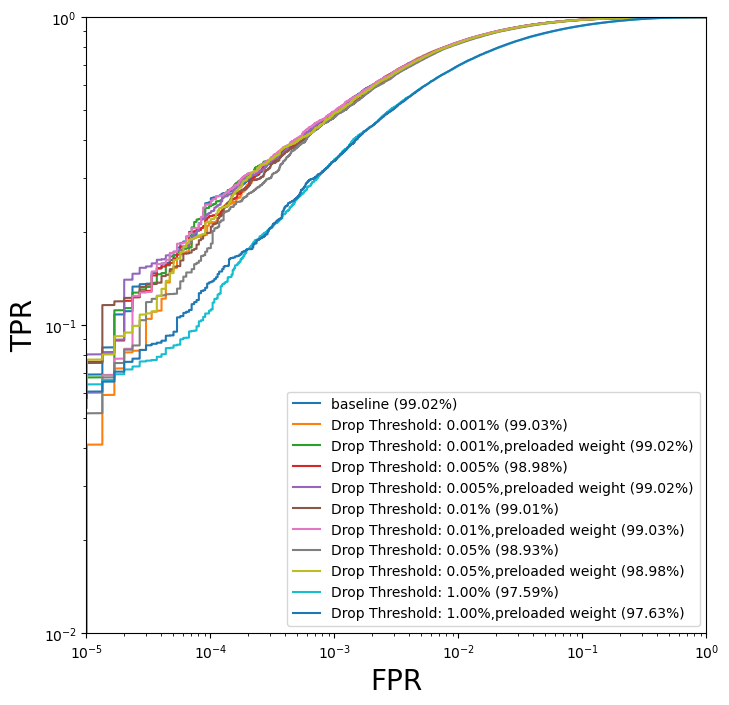

Fidelity for baseline: 100.00
Fidelity for Drop Threshold: 0.001%: 97.56
Fidelity for Drop Threshold: 0.001%,preloaded weight: 99.24
Fidelity for Drop Threshold: 0.005%: 97.56
Fidelity for Drop Threshold: 0.005%,preloaded weight: 99.00
Fidelity for Drop Threshold: 0.01%: 97.59
Fidelity for Drop Threshold: 0.01%,preloaded weight: 98.83
Fidelity for Drop Threshold: 0.05%: 97.46
Fidelity for Drop Threshold: 0.05%,preloaded weight: 98.27
Fidelity for Drop Threshold: 1.00%: 93.15
Fidelity for Drop Threshold: 1.00%,preloaded weight: 93.24


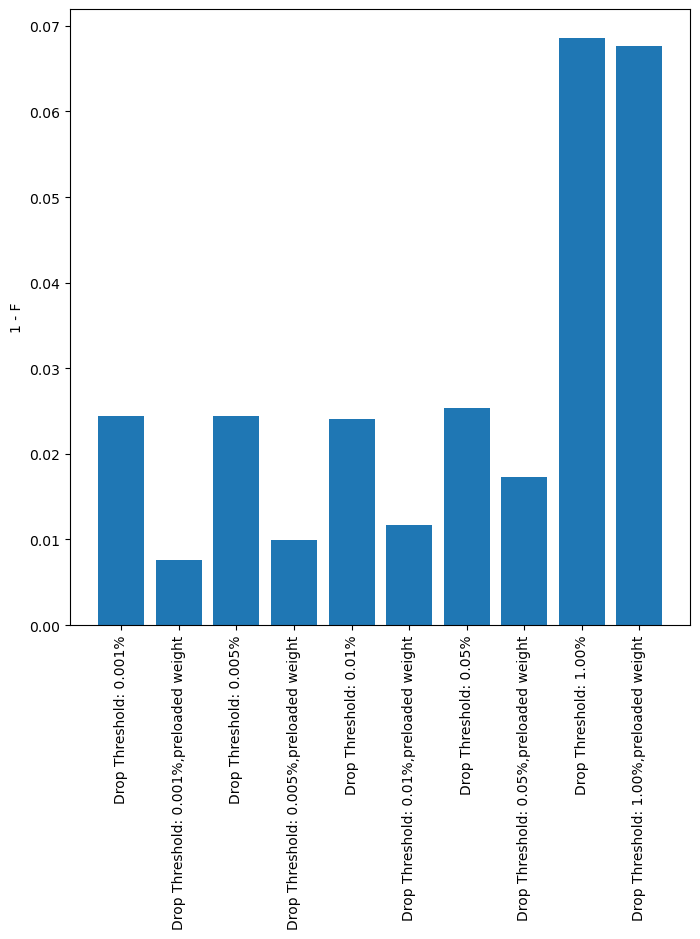

In [7]:
MC = ModelComparison(model_output_preds, model_output_targets, model_output_tags)
MC.plot_roc(fname = "plots_xAI/roc_droptracks_retrained_threshold.png")
fidelity = MC.get_fidelity(model_output_preds[0])
print_scores(vals = fidelity, 
             model_tags = model_output_tags, 
             mode='fidelity' )
fidelity_chart(fidelity_vals = fidelity[1:], 
               tags = model_output_tags[1:], 
               fname = "plots_xAI/fidelity_chart_droptracks_retrained_threshold.png")

In [8]:
import os
All_Models = sorted(list(os.listdir("Model_Dicts/")))
model_output_preds = [pred_0[:,1]]
model_output_targets = [target_0[:,1]]
model_output_tags = ['baseline']

for model_file in All_Models:
    if 'psvfeaturesdropped' not in model_file:
        continue
    if 'hidden' in model_file or 'De' in model_file or 'Do' in model_file:
        continue
    model_md = json.load(open("Model_Dicts/" + model_file))
    model_name = 'IN_training/' + model_file.replace('model_metadata.json', 'best.pth')
    model_tag = model_md['label']
    drop_pfeatures = model_md['drop_pfeatures']
    if drop_pfeatures != "":
        drop_pfeatures = list(map(int, drop_pfeatures.split(','))) 
    else:
        drop_pfeatures = []
        
    drop_svfeatures = model_md['drop_svfeatures']
    if drop_svfeatures != "":
        drop_svfeatures = list(map(int, drop_svfeatures.split(','))) 
    else:
        drop_svfeatures = []
        
    this_gnn = GraphNet(60, 2, len(params) - len(drop_pfeatures), 
                        60, 5, len(params_sv) - len(drop_svfeatures),
                        vv_branch=0,
                        De=20,
                        Do=24)
    this_gnn.load_state_dict(torch.load(model_name))
    pred, target = eval(this_gnn, drop_pfeatures = drop_pfeatures, drop_svfeatures = drop_svfeatures)
    model_output_preds.append(pred[:,1])
    model_output_targets.append(target[:,1])
    threshold = model_tag.split('_')[1]
    threshold = threshold[0] + '.' + threshold[1:]
    if 'preload' not in model_file:
        model_output_tags.append('Drop Threshold: {}%'.format(threshold))
    else:
        model_output_tags.append('Drop Threshold: {}%, preloaded weight'.format(threshold))

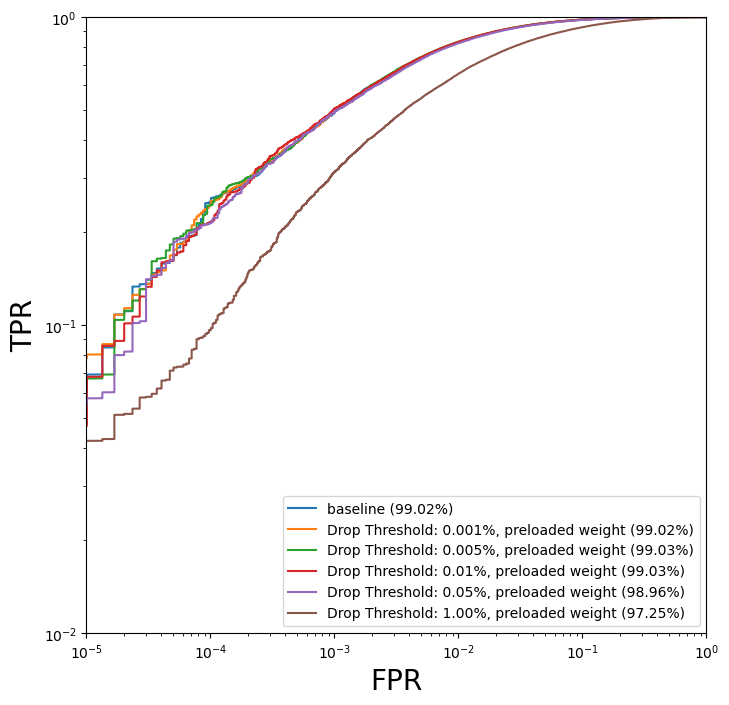

Fidelity for baseline: 100.00
Fidelity for Drop Threshold: 0.001%, preloaded weight: 98.93
Fidelity for Drop Threshold: 0.005%, preloaded weight: 98.83
Fidelity for Drop Threshold: 0.01%, preloaded weight: 98.57
Fidelity for Drop Threshold: 0.05%, preloaded weight: 98.25
Fidelity for Drop Threshold: 1.00%, preloaded weight: 92.15


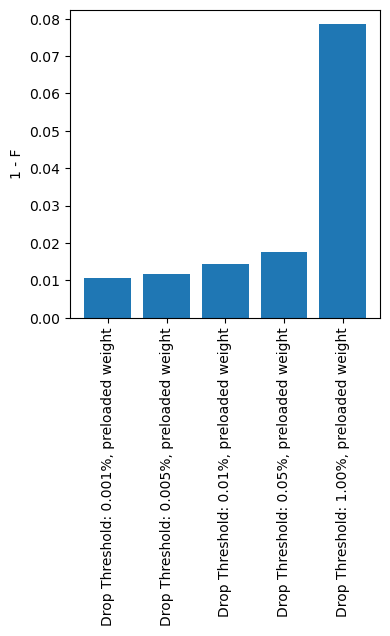

In [9]:
MC = ModelComparison(model_output_preds, model_output_targets, model_output_tags)
MC.plot_roc(fname = "plots_xAI/roc_droptracksNverts_retrained_threshold.png")
fidelity = MC.get_fidelity(model_output_preds[0])
print_scores(vals = fidelity, 
             model_tags = model_output_tags, 
             mode='fidelity' )
fidelity_chart(fidelity_vals = fidelity[1:], 
               tags = model_output_tags[1:], 
               fname = "plots_xAI/fidelity_chart_droptracksNverts_retrained_threshold.png")


# MC.plot_roc()
# fidelity = MC.get_fidelity(model_output_preds[0])

In [10]:
### Now let's get the other models
import os
All_Models = sorted(list(os.listdir("Model_Dicts/")))
model_output_preds = [pred_0[:,1]]
model_output_targets = [target_0[:,1]]
model_output_tags = ['baseline']

for model_file in All_Models:
    if 'pfeaturesdropped' in model_file:
        continue
    if 'hidden' not in model_file and 'De' not in model_file and 'Do' not in model_file:
        continue
    model_md = json.load(open("Model_Dicts/" + model_file))
    model_name = 'IN_training/' + model_file.replace('model_metadata.json', 'best.pth')
    model_tag = model_md['label']
    drop_pfeatures = model_md['drop_pfeatures']
    if drop_pfeatures != "":
        drop_pfeatures = list(map(int, drop_pfeatures.split(','))) 
    else:
        drop_pfeatures = []
        
    drop_svfeatures = model_md['drop_svfeatures']
    if drop_svfeatures != "":
        drop_svfeatures = list(map(int, drop_svfeatures.split(','))) 
    else:
        drop_svfeatures = []
    hidden = model_md['hidden']
    De = model_md['De']
    Do = model_md['Do']
    this_gnn = GraphNet(60, 2, len(params) - len(drop_pfeatures), 
                        hidden, 5, len(params_sv) - len(drop_svfeatures),
                        vv_branch=0,
                        De=De,
                        Do=Do)
    this_gnn.load_state_dict(torch.load(model_name))
    pred, target = eval(this_gnn, drop_pfeatures = drop_pfeatures, drop_svfeatures = drop_svfeatures)
    model_output_preds.append(pred[:,1])
    model_output_targets.append(target[:,1])
    if 'hidden' in model_file:
        model_output_tags.append('Hidden layer nodes: {}'.format(model_file.split('hidden')[1].split('_')[0])
                                )
    if 'De' in model_file:
        model_output_tags.append('De: {}'.format(model_file.split('De')[1].split('_')[0])
                                )
    if 'Do' in model_file:
        model_output_tags.append('Do: {}'.format(model_file.split('Do')[1].split('_')[0])
                                )
#     threshold = model_tag.split('_')[1]
#     threshold = threshold[0] + '.' + threshold[1:]
#     if 'preload' not in model_file:
#         model_output_tags.append('Drop Threshold: {}%, Features Dropped: {}'.format(threshold, 
#                                                                                 len(drop_pfeatures)
#                                                                                 )
#                                 )
#     else:
#         model_output_tags.append('Drop Threshold: {}%, Features Dropped: {}, preloaded weight'.format(threshold, 
#                                                                                                       len(drop_pfeatures)
#                                                                                                      )
#                                 )

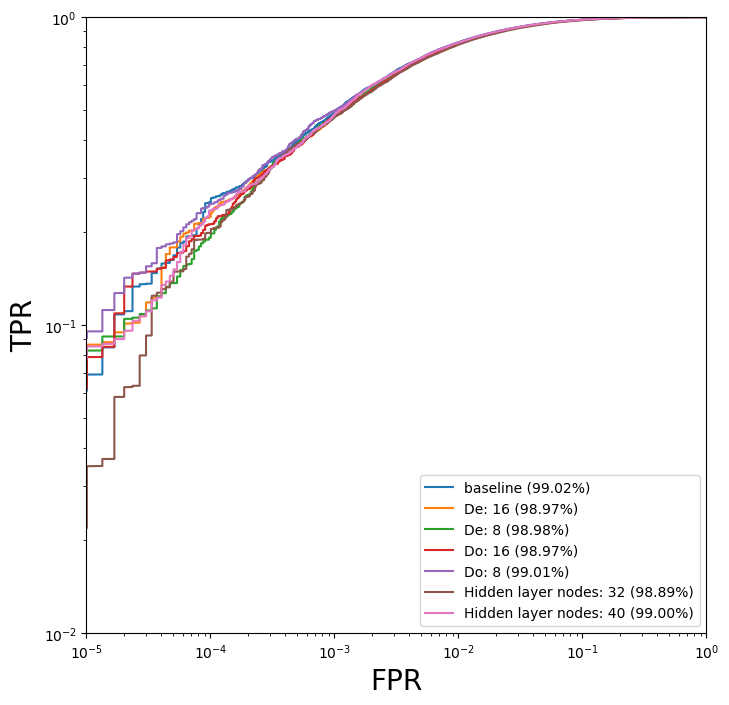

Fidelity for baseline: 100.00
Fidelity for De: 16: 97.50
Fidelity for De: 8: 97.54
Fidelity for Do: 16: 97.60
Fidelity for Do: 8: 97.67
Fidelity for Hidden layer nodes: 32: 97.27
Fidelity for Hidden layer nodes: 40: 97.55


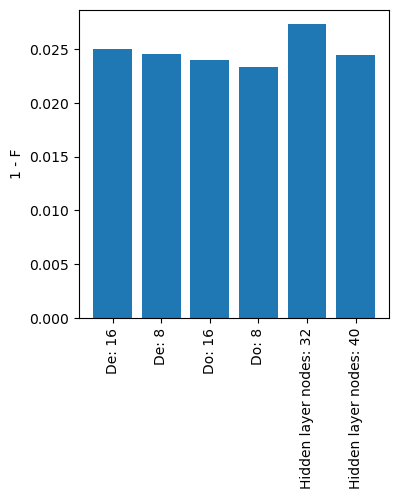

In [11]:
MC = ModelComparison(model_output_preds, model_output_targets, model_output_tags)
MC.plot_roc(fname = "plots_xAI/roc_others_retrained_threshold.png")
fidelity = MC.get_fidelity(model_output_preds[0])
print_scores(vals = fidelity, 
             model_tags = model_output_tags, 
             mode='fidelity' )
fidelity_chart(fidelity_vals = fidelity[1:], 
               tags = model_output_tags[1:], 
               fname = "plots_xAI/fidelity_chart_others_retrained_threshold.png")

In [12]:
### Now let's get the other models
import os
All_Models = sorted(list(os.listdir("Model_Dicts/")))
model_output_preds = [pred_0[:,1]]
model_output_targets = [target_0[:,1]]
model_output_tags = ['baseline']

for model_file in All_Models:
    if 'pfeaturesdropped' not in model_file:
        continue
    if 'hidden' not in model_file and 'De' not in model_file and 'Do' not in model_file:
        continue
    model_md = json.load(open("Model_Dicts/" + model_file))
    model_name = 'IN_training/' + model_file.replace('model_metadata.json', 'best.pth')
    model_tag = model_md['label']
    drop_pfeatures = model_md['drop_pfeatures']
    if drop_pfeatures != "":
        drop_pfeatures = list(map(int, drop_pfeatures.split(','))) 
    else:
        drop_pfeatures = []
        
    drop_svfeatures = model_md['drop_svfeatures']
    if drop_svfeatures != "":
        drop_svfeatures = list(map(int, drop_svfeatures.split(','))) 
    else:
        drop_svfeatures = []
    hidden = model_md['hidden']
    De = model_md['De']
    Do = model_md['Do']
    this_gnn = GraphNet(60, 2, len(params) - len(drop_pfeatures), 
                        hidden, 5, len(params_sv) - len(drop_svfeatures),
                        vv_branch=0,
                        De=De,
                        Do=Do)
    this_gnn.load_state_dict(torch.load(model_name))
    pred, target = eval(this_gnn, drop_pfeatures = drop_pfeatures, drop_svfeatures = drop_svfeatures)
    model_output_preds.append(pred[:,1])
    model_output_targets.append(target[:,1])
    model_output_tags.append(model_tag)
#     if 'hidden' in model_file:
#         model_output_tags.append('Hidden layer nodes: {}'.format(model_file.split('hidden')[1].split('_')[0])
#                                 )
#     if 'De' in model_file:
#         model_output_tags.append('De: {}'.format(model_file.split('De')[1].split('_')[0])
#                                 )
#     if 'Do' in model_file:
#         model_output_tags.append('Do: {}'.format(model_file.split('Do')[1].split('_')[0])
#                                 )

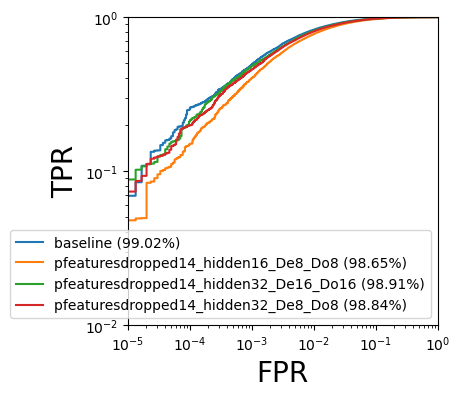

Fidelity for baseline: 100.00
Fidelity for pfeaturesdropped14_hidden16_De8_Do8: 96.39
Fidelity for pfeaturesdropped14_hidden32_De16_Do16: 97.27
Fidelity for pfeaturesdropped14_hidden32_De8_Do8: 97.05


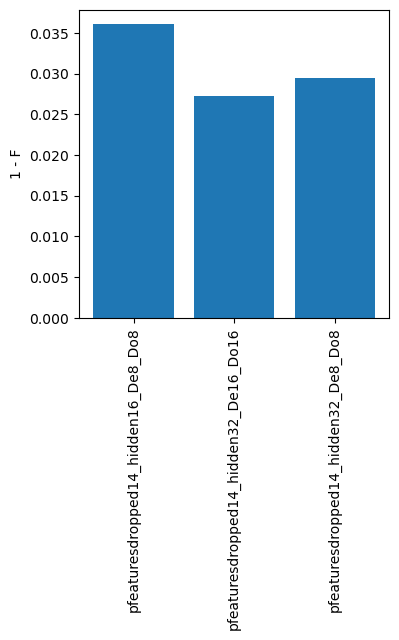

In [13]:
MC = ModelComparison(model_output_preds, model_output_targets, model_output_tags)
MC.plot_roc(fname = "plots_xAI/roc_others2_retrained_threshold.png")
fidelity = MC.get_fidelity(model_output_preds[0])
print_scores(vals = fidelity, 
             model_tags = model_output_tags, 
             mode='fidelity' )
fidelity_chart(fidelity_vals = fidelity[1:], 
               tags = model_output_tags[1:], 
               fname = "plots_xAI/fidelity_chart_others2_retrained_threshold.png")